In [35]:
import os
import random
from skimage import data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import array
from sklearn.model_selection import train_test_split


In [36]:
%matplotlib inline

## Parse and Load the Training Data

In [37]:
def load_data(path):
    #print('file_name: ',path)
    images = []
    #file_names = sorted(os.listdir(path)) 
    file_names = sorted(os.listdir(path),key=lambda x: int(os.path.splitext(x)[0]))
    for f in file_names:
        #print('Image_file_name: ',f)
        images.append(data.imread(os.path.join(path, f)))
    return images

def load_label(filename):    
    labels = []
    file = open(filename, 'r') 
    for line in file:
        #print(line)
        labels.append(line.strip('\n'))
    print('label_file_name written: ',filename)
    file.close()
    return labels
    

path = '/home/ubuntu/ttr/TicketToRide'
labelfilename='threeTestSegment.txt'
train_data_directory=os.path.join(path,'Just3')
labelfile=os.path.join(path,labelfilename)
    
images = load_data(train_data_directory)
labels=load_label(labelfile)

print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))


label_file_name written:  /home/ubuntu/ttr/TicketToRide/threeTestSegment.txt
Unique Labels: 3
Total Images: 139


In [ ]:
print(images.ndim)
print(images.size)
#print(images[0])


Display the first image of each label

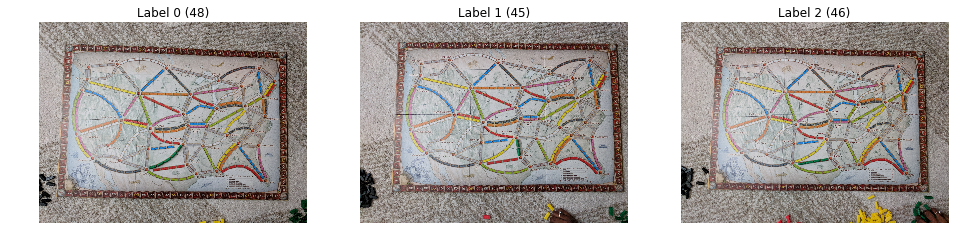

In [82]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(45, 45))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

In [39]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (3036, 4048, 3), min: 0, max: 255
shape: (3036, 4048, 3), min: 0, max: 255
shape: (3036, 4048, 3), min: 0, max: 255
shape: (3036, 4048, 3), min: 0, max: 255
shape: (3036, 4048, 3), min: 0, max: 255


/home/ubuntu/anaconda3/envs/tf/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


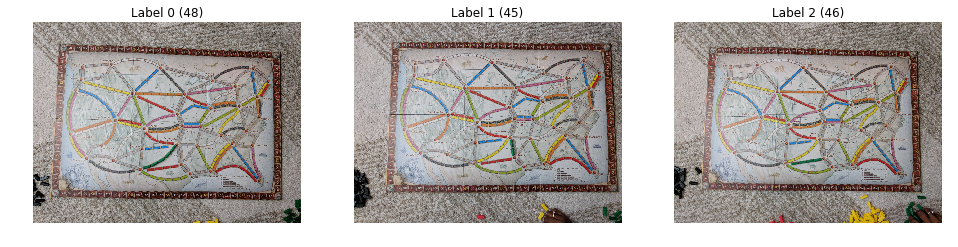

In [83]:
# Resize images
images32 = [skimage.transform.resize(image, (759, 1012))
                for image in images]
display_images_and_labels(images32, labels)

In [41]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (759, 1012, 3), min: 0.0, max: 0.9617647058823534
shape: (759, 1012, 3), min: 0.0, max: 0.9647058823529518
shape: (759, 1012, 3), min: 0.0, max: 0.9794117647058653
shape: (759, 1012, 3), min: 0.0, max: 0.992156862745118
shape: (759, 1012, 3), min: 0.0, max: 0.9990196078431355


## Minimum Viable Model

In [42]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)


labels:  (139,) 
images:  (139, 759, 1012, 3)


In [44]:
print("Labels")
print(labels_a)
## #Print the `labels` dimensions
print(labels_a.ndim)
##
## #Print the number of `labels`'s elements
print(labels_a.size)
##
## ##Count the number of labels
print(len(set(labels_a)))

Labels
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2']
1
139
3


## Creating the graph

In [76]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 759, 1012, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 3]
    logits = tf.contrib.layers.fully_connected(images_flat, 3, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.initialize_all_variables()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 2304324), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 3), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


## Create training and test datas

In [77]:
X_train, X_test, y_train, y_test = train_test_split(images_a, labels_a, test_size=0.33, random_state=42)

print(y_train)


['2' '0' '0' '2' '0' '0' '2' '2' '2' '0' '0' '1' '2' '0' '0' '1' '0' '1'
 '1' '1' '1' '1' '0' '2' '1' '1' '0' '0' '2' '0' '0' '1' '1' '2' '2' '0'
 '0' '2' '0' '0' '0' '1' '2' '0' '2' '2' '2' '1' '1' '2' '0' '2' '1' '2'
 '1' '2' '1' '0' '1' '1' '1' '1' '2' '2' '1' '1' '0' '2' '1' '1' '2' '0'
 '0' '2' '2' '0' '1' '0' '0' '0' '2' '2' '2' '1' '1' '2' '2' '0' '1' '2'
 '0' '1' '2']


In [78]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [79]:
for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: X_train, labels_ph: y_train})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  1.10867
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861
Loss:  1.09861


In [53]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

['1', '2', '2', '2', '1', '0', '0', '1', '0', '2']
[0 0 0 0 0 0 0 0 0 0]


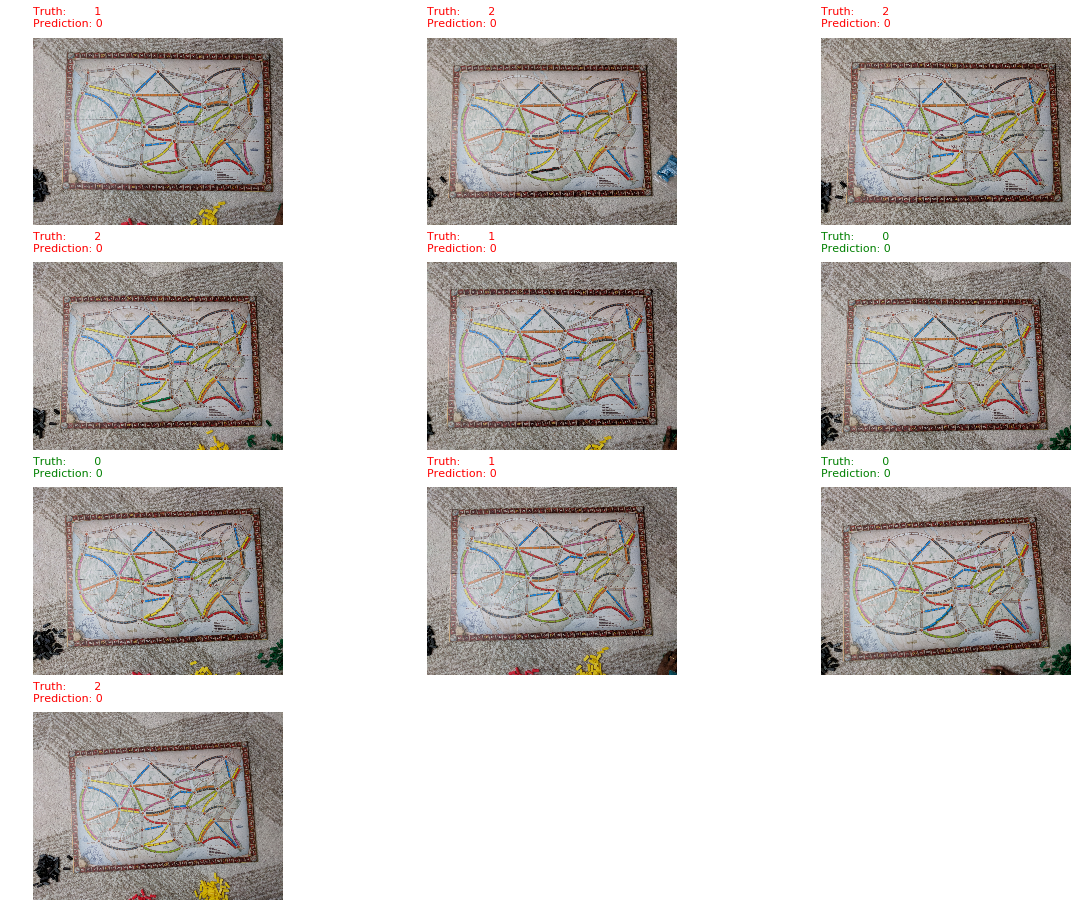

In [71]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(20, 20))
for i in range(len(sample_images)):
    truth = int(sample_labels[i])
    prediction = int(predicted[i])
    plt.subplot(5, 3,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(0, 0, "Truth:        {0}\nPrediction: {1}\n".format(truth, prediction), 
             fontsize=11, color=color)
    plt.imshow(sample_images[i])